In [7]:
import firebase_admin
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from firebase_admin import credentials, firestore
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import math

# Firebase Initialization
cred = credentials.Certificate("adminkey.json")
#firebase_admin.initialize_app(cred)
db = firestore.client()

# Constants
INCLUDE_ONLY = ['44444']
ACTIVITIES = ['sit', 'walk', 'upstairs']
SAMPLING_RATE = 100
OVERLAP = 0.5
CHUNK_SIZE = 1
BATCH_SIZE = 64
EPOCHS = 100
LEARNING_RATE = 0.001
DIFF_THRESHOLD = 35

In [8]:
def fetch_data_by_treatment(treatment_filter):
    data_raw, docs = [], []
    data_ref = db.collection("data").document(treatment_filter)

    for patient_id in INCLUDE_ONLY:
        subject_ref = data_ref.collection(patient_id)
        for activity in ACTIVITIES:
            activity_ref = subject_ref.document(activity)
            phone_location_col = activity_ref.collections()

            for phone_location in phone_location_col:
                for recording in phone_location.stream():
                    record = recording.to_dict()
                    if 'acceleration' not in record:
                        continue
                    df = pd.DataFrame(record['acceleration'])
                    timestamps = df['timestamp']
                    min_time = timestamps.min()
                    max_time = timestamps.max()
                    df = df[(timestamps >= min_time + 2500) & (timestamps <= max_time - 2500)]
                    if df.empty:
                        continue
                    combined = pd.DataFrame({
                        'ax': df['accelerometer'].apply(lambda x: x['x']),
                        'ay': df['accelerometer'].apply(lambda x: x['y']),
                        'az': df['accelerometer'].apply(lambda x: x['z']),
                        'gx': df['gyroscope'].apply(lambda x: x['x']),
                        'gy': df['gyroscope'].apply(lambda x: x['y']),
                        'gz': df['gyroscope'].apply(lambda x: x['z']),
                    })
                    data_raw.append(combined)
                    docs.append({'activity': activity})
    return data_raw, docs

def chunk_data_raw(data_raw, docs, chunk_size_sec, sampling_rate, overlap=OVERLAP):
    data, labels = [], []
    chunk_samples = int(chunk_size_sec * sampling_rate)
    step = int(chunk_samples * (1 - overlap))
    for i, df in enumerate(data_raw):
        for start in range(0, len(df) - chunk_samples + 1, step):
            chunk = df.iloc[start:start + chunk_samples]
            if len(chunk) == chunk_samples:
                data.append(chunk.values)
                labels.append(ACTIVITIES.index(docs[i]['activity']))
    return np.array(data), np.array(labels)

In [9]:
class PositionalEncoding(nn.Module):
    def __init__(self, emb_size, dropout=0.1, maxlen=5000):
        super().__init__()
        self.dropout = nn.Dropout(dropout)
        pe = torch.zeros(maxlen, emb_size)
        position = torch.arange(0, maxlen, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, emb_size, 2).float() * (-math.log(10000.0) / emb_size))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)
    def forward(self, x):
        x = x + self.pe[:, :x.size(1), :]
        return self.dropout(x)

class TransformerClassifier(nn.Module):
    def __init__(self, input_dim=6, emb_size=128, nhead=8, nhid=128, nlayers=3, nclasses=len(ACTIVITIES), dropout=0.1):
        super().__init__()
        self.embedding = nn.Linear(input_dim, emb_size)
        self.pos_encoder = PositionalEncoding(emb_size, dropout)
        encoder_layer = nn.TransformerEncoderLayer(d_model=emb_size, nhead=nhead, dim_feedforward=nhid, dropout=dropout)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=nlayers)
        self.classifier = nn.Linear(emb_size, nclasses)
        self.emb_size = emb_size
    def forward(self, x):
        x = self.embedding(x) * math.sqrt(self.emb_size)
        x = self.pos_encoder(x)
        x = x.permute(1, 0, 2)
        x = self.transformer_encoder(x)
        x = x.mean(dim=0)
        x = self.classifier(x)
        return x

In [10]:
def train_and_evaluate_before_after():
    # Fetch BeforeTreatment data
    before_raw, before_docs = fetch_data_by_treatment('BeforeTreatment')
    X_train_full, y_train_full = chunk_data_raw(before_raw, before_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)
    # Split into train-val
    X_train_np, X_val_np, y_train_np, y_val_np = train_test_split(X_train_full, y_train_full, test_size=0.2, random_state=42, stratify=y_train_full)

    # Fetch AfterTreatment data
    after_raw, after_docs = fetch_data_by_treatment('AfterTreatment')
    X_test_np, y_test_np = chunk_data_raw(after_raw, after_docs, CHUNK_SIZE, SAMPLING_RATE, OVERLAP)

    # Convert to tensors
    X_train = torch.tensor(X_train_np, dtype=torch.float32)
    y_train = torch.tensor(y_train_np, dtype=torch.long)
    X_val = torch.tensor(X_val_np, dtype=torch.float32)
    y_val = torch.tensor(y_val_np, dtype=torch.long)
    X_test = torch.tensor(X_test_np, dtype=torch.float32)
    y_test = torch.tensor(y_test_np, dtype=torch.long)

    train_ds = TensorDataset(X_train, y_train)
    val_ds = TensorDataset(X_val, y_val)
    test_ds = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE)
    test_loader = DataLoader(test_ds, batch_size=BATCH_SIZE)

    device = torch.device('cpu')
    model = TransformerClassifier().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

    # Training loop
    for epoch in range(EPOCHS):
        model.train()
        total_correct, total = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            optimizer.zero_grad()
            preds = model(xb)
            loss = criterion(preds, yb)
            loss.backward()
            optimizer.step()
            total_correct += (preds.argmax(dim=1) == yb).sum().item()
            total += yb.size(0)
        train_acc = total_correct / total * 100

        # Validation
        model.eval()
        val_correct, val_total = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                preds = model(xb)
                val_correct += (preds.argmax(dim=1) == yb).sum().item()
                val_total += yb.size(0)
        val_acc = val_correct / val_total * 100

        print(f"Epoch {epoch+1}/{EPOCHS} | Train Acc: {train_acc:.2f}% | Val Acc: {val_acc:.2f}%")

    # Test evaluation
    model.eval()
    test_correct, test_total = 0, 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb)
            test_correct += (preds.argmax(dim=1) == yb).sum().item()
            test_total += yb.size(0)
            all_preds.extend(preds.argmax(dim=1).cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    test_acc = test_correct / test_total * 100
    print(f"\nTest Accuracy (AfterTreatment): {test_acc:.2f}%")
    print(classification_report(all_labels, all_preds, target_names=ACTIVITIES))

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6,5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=ACTIVITIES, yticklabels=ACTIVITIES)
    plt.title('Test Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    acc_diff = abs(train_acc - test_acc)
    if acc_diff >= DIFF_THRESHOLD:
        print(f"Train-Test accuracy differs by {acc_diff:.2f}%, exceeds threshold. Data is different before vs after.")
    else:
        print(f"Train-Test accuracy differs by only {acc_diff:.2f}%, within threshold. Data is similar before vs after.")

c:\users\yuanh\appdata\local\programs\python\python38\lib\site-packages\torch\nn\modules\transformer.py:307: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


Epoch 1/100 | Train Acc: 47.83% | Val Acc: 79.31%
Epoch 2/100 | Train Acc: 82.61% | Val Acc: 79.31%
Epoch 3/100 | Train Acc: 83.48% | Val Acc: 82.76%
Epoch 4/100 | Train Acc: 83.48% | Val Acc: 89.66%
Epoch 5/100 | Train Acc: 86.96% | Val Acc: 93.10%
Epoch 6/100 | Train Acc: 88.70% | Val Acc: 89.66%
Epoch 7/100 | Train Acc: 87.83% | Val Acc: 89.66%
Epoch 8/100 | Train Acc: 90.43% | Val Acc: 89.66%
Epoch 9/100 | Train Acc: 94.78% | Val Acc: 89.66%
Epoch 10/100 | Train Acc: 93.91% | Val Acc: 93.10%
Epoch 11/100 | Train Acc: 96.52% | Val Acc: 89.66%
Epoch 12/100 | Train Acc: 97.39% | Val Acc: 89.66%
Epoch 13/100 | Train Acc: 97.39% | Val Acc: 93.10%
Epoch 14/100 | Train Acc: 95.65% | Val Acc: 93.10%
Epoch 15/100 | Train Acc: 95.65% | Val Acc: 96.55%
Epoch 16/100 | Train Acc: 100.00% | Val Acc: 100.00%
Epoch 17/100 | Train Acc: 96.52% | Val Acc: 96.55%
Epoch 18/100 | Train Acc: 97.39% | Val Acc: 96.55%
Epoch 19/100 | Train Acc: 98.26% | Val Acc: 100.00%
Epoch 20/100 | Train Acc: 100.00% | V

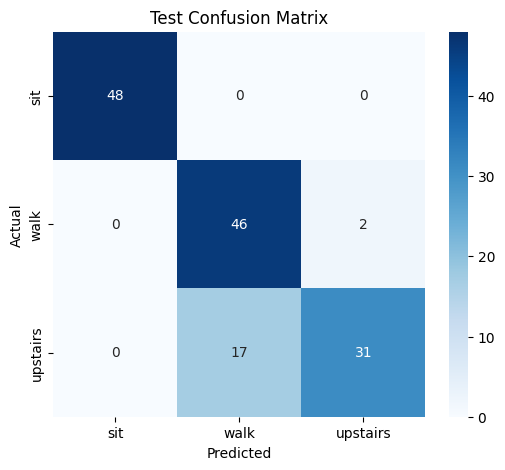

Train-Test accuracy differs by only 13.19%, within threshold. Data is similar before vs after.


In [11]:
if __name__ == "__main__":
    train_and_evaluate_before_after()